Hunter Bennett  
Glass Lab  
Created 180205 | Last updated 180205  
____________  
here we are seeking to understand if there are noticeable molecular phenotype within 4 weeks on the NASH diet.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
#  %load_ext rpy2.ipython

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In local({ :
  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  bytecode version mismatch; using eval

  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: There were 13 warnings (use warnings() to see them)
  warnings.warn(x, RRuntimeWarning)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarn

LookupError: 'show' not found

In [2]:
# define path to data
datapath = {'kupffer':'/data/mm10/Kupffer/RNA/'}

# define output directory
outdir = '/home/h1bennet/liverStrains/results/180412_RNA_4wk/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

# define samples for both whole liver and kupffer
samples = {'kupffer':["mouse_NCoRWT_M_KupfferTim4Pos_RNA_polyA_AMLN4week_JSSTDT_LN352A_JSS_l20180314_ATCACG",
                      "mouse_NCoRWT_M_KupfferTim4Pos_RNA_polyA_AMLN4week_JSSTDT_LN354D_JSS_l20180314_CATGGC",
                      "C57BL6_Tim4PosKup_RNA_polyA_AMLN_1Week_flavopiriodol_C574A_sorted170420_JSS_TDT_17_05_10",
                      "C57BL6_Tim4PosKup_RNA_polyA_AMLN_1Week_flavopiriodol_C574B_JSS_TDT_17_05_10",
                      "NCoRWT_Kupffer_RNA_polyA_Vehicle_8h_Flavopiridol_LN12aM_JSS_15_08_12",
                      "NCoRWt_Kupffer_RNA_polyA_Vehicle_8h_Flavopiridol_LN36cM_JSS_15_10_16",
                      "NCoRWt_Kupffer_RNA_polyA_Vehicle_8h_Flavopiridol_LN38aM_JSS_15_10_21"]}

bad_samples = {'LN140D': 'cancer', 'LN136B': 'cancer', 'LN148B': 'cancer',
              'LN144A': 'cancer', 'LN144C': 'cancer', 'LN182B': 'cancer',
              'LN182B': 'cancer', 'LN203B': 'cancer', 'BALB3A': 'splenomegaly',
              'BALB4D': 'hyper-fibrosis', 'LN148B': 'cancer', 'LN166A': 'cancer'}

In [3]:
# define sample data frame
samplesDF = pd.DataFrame([s for groups in samples.values() for s in groups], columns = ['subject'])
samplesDF['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF.subject]
samplesDF['path'] = [datapath[key] + s for key in datapath.keys() for s in samples[key]]
samplesDF['batch'] = pd.factorize(samplesDF.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]

samplesDF['diet'] = ['AMLN' if 'AMLN' in name else 'Control' for name in samplesDF.subject]
samplesDF['time'] = ['4wk', '4wk', '1wk', '1wk', '0wk', '0wk', '0wk']

samplesDF['diet_time'] = samplesDF.diet + '_' + samplesDF.time
samplesDF['exclusion'] = samplesDF.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)
samplesDF['mouse'] = samplesDF.subject.str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)

In [4]:
# set colors for the samples
color_dict = {'AMLN_4wk':'#006d2c', 'AMLN_1wk':'#74c476', 'Control_0wk':'#c7e9c0'}
samplesDF['color'] = [color_dict[group] for group in samplesDF.diet_time]

# write out samplesDF
samplesDF.to_csv(outdir + 'amln_samples.txt', sep='\t')

In [5]:
# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/LXR/data/mm10_refseq_genename.txt', sep='\t', names=['refseq_id', 'gene'], index_col=0)

Set some user defined functions

In [6]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = hbUtils.df_col_subset(tpm, strain + '.*' + tissue)
    tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)
    tmp_df.columns = pd.Series(tmp_df.columns).replace(np.nan, 'NNaF')
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)
        
def makeHub(samplelist, name, genome, plotoption=None, force=True):
    '''Takes a list of samples and runs the homer makeMultiWigHub.pl command with them
    '''
    mwcall = ['makeMultiWigHub.pl', name, genome]
    if plotoption != None:
        mwcall.extend(['-'+plotoption])
    mwcall.extend(['-url', 'http://homer.ucsd.edu/hubs/',
            '-webdir', '/homer_data/www/html/hubs'])
    if force:
        mwcall.extend(['-force'])
    mwcall.extend(['-d'])
    mwcall.extend(list(samplelist))
    subprocess.call(mwcall)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def process_rpkm(rpkm, conv_tpm = False):
    rpkm = rpkm.loc[rpkm.Length >= 200, :]

    # Create column for gene
    rpkm.loc[:, 'Gene'] = pd.Series([x.split('|')[0] for x in rpkm['Annotation/Divergence']])

    # clean up the columns a bit
    pattern = r"\s+\(.+\)$"
    rpkm.columns = pd.Series(rpkm.columns)\
            .str.replace(pattern, '')\
            .str.split('/')\
            .str[-1]
        
    #subset matrix of only counts
    rpkm_mat = rpkm.set_index('RepeatID').loc[:, rpkm.columns[
            rpkm.columns.to_series().str.contains('RNA')]]

    # create tpm matrix
    if conv_tpm:
        tpm_mat = rpkm_mat.apply(lambda x: x * (10**6)/x.sum())
        return tpm_mat
    else:
        return rpkm_mat

In [7]:
# Make UCSC browser hub for data
# makeHub(samplesDF.loc[:, 'path'], 'hrb_c57bl6_amln_4wk1wk', 'mm10')

#### Anotate the RNA Seq Samples using python wrapper for annotateRepeats from the Homer package

In [8]:
# set analyses we want to do 
# No longer include genes. After discussion with Ty Troutman running analyzeRepeats with
# the 'condenseGenes' flag will collapse transcripts into one. Thus the ideal way to do
# RNA Seq for now is 'exons' - count only in exons, along with condenseGenes.
analyses = [('exons', False, None),
            ('exons', True, None),
            ('exons', False, 'rlog'), # ignore the rlog transform values for now
            ('exons', False, 'rpkm')]

In [9]:
# run annotate repeats with set of analysis options
for count_type, raw, norm in analyses:
    
    # generate file name
    filename = outdir + '/rnaseq_matrix_condenseGenes_' + count_type
    if raw:
        filename += '_raw'
    if norm != None:
        filename += ('_'+ str(norm))
    filename += '.txt'
    
    # run annotate repeats
    if not os.path.isfile(filename):
        out, err = hbUtils.run_annotateRepeats(samplesDF.path,
                countType=count_type, raw=raw, norm=norm, print_out=True)
        f = open(filename, 'w')
        f.write(out.decode('utf-8'))
        f.close()
        print(err.decode('utf-8'))

###  First take a look at pairwise scatterplots of the individuals

we will use a tpm matrix for most of our plotting

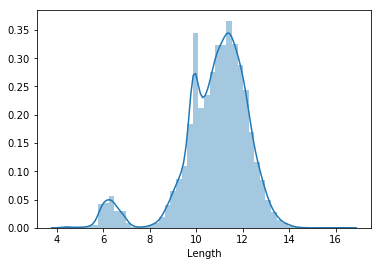

In [10]:
rpkm = pd.read_csv(outdir + '/rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')
sns.distplot(np.log2(rpkm.Length + 1))

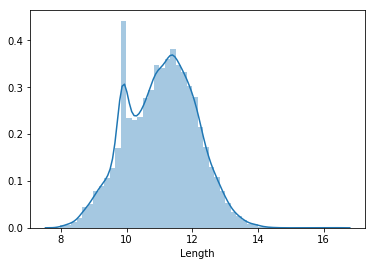

In [11]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 250, :]
sns.distplot(np.log2(rpkm.Length + 1))

In [12]:
tpm_mat = process_rpkm(rpkm, conv_tpm=True)

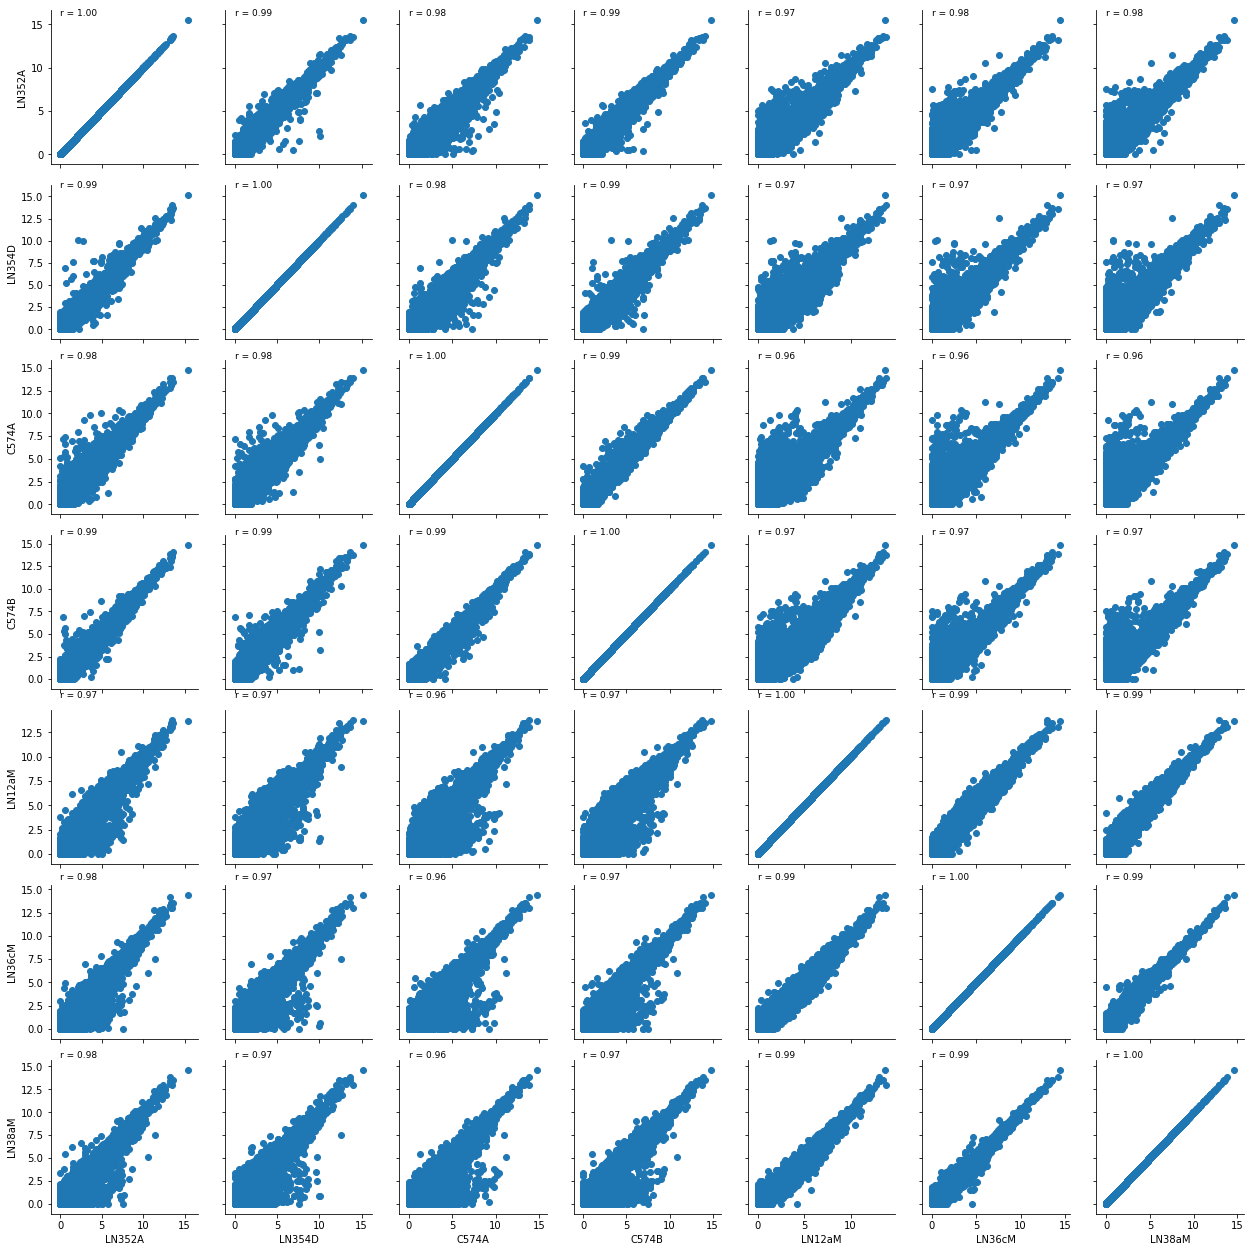

In [13]:
tpm_paired_scatter(tpm_mat, '', tissue='')

# Descriptive analysis of our data

lets do this just with Tim4Pos cells

In [14]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_mat)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.diet_time])).reset_index()
tpm_pca_df['mouse'] = samplesDF['mouse']

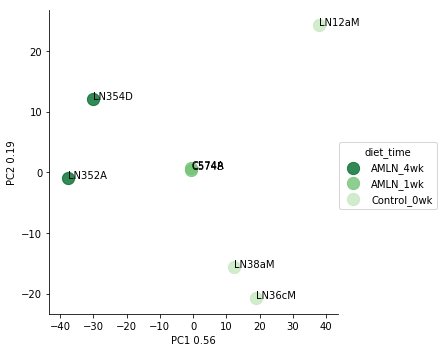

In [15]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='diet_time', palette=color_dict,
                size=5, scatter_kws={'s': 150})
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.mouse, plt.gca())

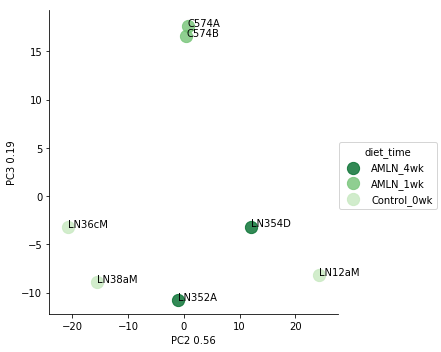

In [16]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='diet_time', palette=color_dict,
                size=5, scatter_kws={'s': 150})
ax.set(xlabel=('PC2 %.2f' % exp_var[0]), ylabel=('PC3 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC2, tpm_pca_df.PC3, tpm_pca_df.mouse, plt.gca())

In [17]:
transcript_pc = pd.DataFrame(pca.components_.T, tpm_mat.index, columns=['PC1','PC2','PC3'])

In [18]:
# look at the genes with the highest loading in PC1
transcript_pc.sort_values(by = 'PC1', ascending=False).head(10)

,PC1,PC2,PC3
RepeatID,,,
NM_010545,0.219294,0.055831,-0.108646
NM_021278,0.192353,-0.445625,0.294498
NM_009735,0.186387,-0.067663,0.234003
NM_017372,0.140876,-0.143008,0.134609
NM_001081957,0.137433,-0.191382,0.067456
NM_016917,0.126137,0.052928,-0.123524
NM_007574,0.118169,-0.079283,-0.234260
NM_016751,0.115825,-0.181962,0.067334
NM_177789,0.114927,-0.049229,-0.054806


### Heatmap

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


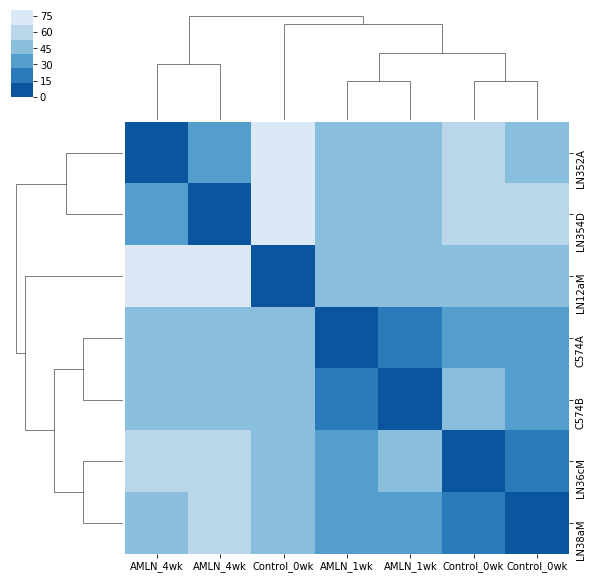

In [19]:
from scipy.spatial import distance
tpm_dist = pd.DataFrame(distance.squareform(distance.pdist(tpm_std.T, 'euclidean')),
                        columns = list(samplesDF.diet_time),
                        index = list(samplesDF.mouse))
# plot values using sns clustermap - ignore error as we know we are putting in a distance mat
g = sns.clustermap(tpm_dist, cmap=sns.color_palette("Blues_r"))

## Differential Analysis (DESeq2)

### Prep data for R

In [20]:
raw_counts_file = '/rnaseq_matrix_condenseGenes_exons_raw.txt'
counts_df = pd.read_csv(outdir + raw_counts_file, sep='\t')

In [21]:
# import the raw count file
raw_counts_file = '/rnaseq_matrix_condenseGenes_exons_raw.txt'
counts_df = pd.read_csv(outdir + raw_counts_file, sep='\t')

# remove samples with length < 250bp
counts_df = counts_df.loc[counts_df.Length >= 250, :]

# create gene name column
counts_df['gene'] = counts_df['Annotation/Divergence'].str.split('|').str[0]

# clean up columns
counts_df.columns = pd.Series(counts_df.columns)\
        .str.split(r" \(").str[0]\
        .str.split('/.*/').str[-1]
counts_df = counts_df.set_index('Transcript/RepeatID')

#### Write the data for DESeq2

In [22]:
# raw count matrix for DESeq
raw_counts_deseq = raw_counts_file.replace('.txt', '_mat_deseq.txt')
counts_df.iloc[:,7:-1].to_csv(outdir + raw_counts_deseq, sep='\t')

# Column Data Information for DESeq, make sure to drop the samples we are excluding
col_data = samplesDF.loc[:, ['subject', 'diet', 'diet_time', 'sample_type']]
col_data = col_data.set_index('subject')
col_file = raw_counts_file.replace('.txt', '_deseq_col_info.txt')
col_data.to_csv(outdir + col_file, sep='\t')

# ~*~* Since RPY2 isnt working this is we do DESeq2 in a magical notebook far far away ~*~*

# Import DESeq2 results

### 4 week diet effect

In [23]:
deseq_4wk = pd.read_csv(outdir + '/rnaseq_c57bl6_amln_4wk_deseq_results.txt', sep=',')

In [24]:
# create annotation file
deseq_4wk_anno = pd.merge(deseq_4wk, counts_df.iloc[:, :7], left_on = 'Unnamed: 0', right_index=True)
deseq_4wk_anno['gene'] = deseq_4wk_anno['Annotation/Divergence'].str.split('|').str[0]
deseq_4wk_anno.to_csv(outdir + '/rnaseq_c57bl6_amln_4wk_deseq_results_anno.txt', sep='\t')

In [25]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

# get gene lists
c57bl6_amln_4wk_deseq_p01_fc2_up = deseq_4wk_anno.loc[
        ((deseq_4wk_anno.padj <= pval) & (deseq_4wk_anno.log2FoldChange > fc)), 'gene']

c57bl6_amln_4wk_deseq_p01_fc2_dn = deseq_4wk_anno.loc[
        ((deseq_4wk_anno.padj <= pval) & (deseq_4wk_anno.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open(outdir + '/c57bl6_amln_4wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['refseqid'] +  c57bl6_amln_4wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open(outdir + '/c57bl6_amln_4wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['refseqid'] +  c57bl6_amln_4wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 1 week diet effect

In [26]:
# read in 1 wk DESeq2 table
deseq_1wk = pd.read_csv(outdir + '/rnaseq_c57bl6_amln_1wk_deseq_results.txt', sep=',')

In [27]:
# create annotation file
deseq_1wk_anno = pd.merge(deseq_1wk, counts_df.iloc[:, :7], left_on = 'Unnamed: 0', right_index=True)
deseq_1wk_anno['gene'] = deseq_1wk_anno['Annotation/Divergence'].str.split('|').str[0]
deseq_1wk_anno.to_csv(outdir + '/rnaseq_c57bl6_amln_1wk_deseq_results_anno.txt', sep='\t')

In [28]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

# get gene lists
c57bl6_amln_1wk_deseq_p01_fc2_up = deseq_1wk_anno.loc[
        ((deseq_1wk_anno.padj <= pval) & (deseq_1wk_anno.log2FoldChange > fc)), 'gene']

c57bl6_amln_1wk_deseq_p01_fc2_dn = deseq_1wk_anno.loc[
        ((deseq_1wk_anno.padj <= pval) & (deseq_1wk_anno.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open(outdir + '/c57bl6_amln_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['refseqid'] +  c57bl6_amln_1wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open(outdir + '/c57bl6_amln_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['refseqid'] +  c57bl6_amln_1wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 4 vs 1 week diet effect

In [29]:
# read in 1 wk vs 4 wk DESeq2 table
deseq_4wk_1wk = pd.read_csv(outdir + '/rnaseq_c57bl6_amln_4wk_1wk_deseq_results.txt', sep=',')

In [30]:
# create annotation file
deseq_4wk_1wk_anno = pd.merge(deseq_4wk_1wk, counts_df.iloc[:, :7], left_on = 'Unnamed: 0', right_index=True)
deseq_4wk_1wk_anno['gene'] = deseq_4wk_1wk_anno['Annotation/Divergence'].str.split('|').str[0]
deseq_4wk_1wk_anno.to_csv(outdir + '/rnaseq_c57bl6_amln_4wk_1wk_deseq_results_anno.txt', sep='\t')

In [31]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

# get gene lists
c57bl6_amln_4wk_1wk_deseq_p01_fc2_up = deseq_4wk_1wk_anno.loc[
        ((deseq_4wk_1wk_anno.padj <= pval) & (deseq_4wk_1wk_anno.log2FoldChange > fc)), 'gene']

c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn = deseq_4wk_1wk_anno.loc[
        ((deseq_4wk_1wk_anno.padj <= pval) & (deseq_4wk_1wk_anno.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open(outdir + '/c57bl6_amln_4wk_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['refseqid'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open(outdir + '/c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['refseqid'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### Metascape Analysis done offline

# Comparing Differential Gene Expression

In [32]:
samplesDF['diet_time_mouse'] = samplesDF['diet_time'] + '_' + samplesDF['mouse']

In [33]:
samplesDF.subject + ' FPKM'

0    mouse_NCoRWT_M_KupfferTim4Pos_RNA_polyA_AMLN4w...
1    mouse_NCoRWT_M_KupfferTim4Pos_RNA_polyA_AMLN4w...
2    C57BL6_Tim4PosKup_RNA_polyA_AMLN_1Week_flavopi...
3    C57BL6_Tim4PosKup_RNA_polyA_AMLN_1Week_flavopi...
4    NCoRWT_Kupffer_RNA_polyA_Vehicle_8h_Flavopirid...
5    NCoRWt_Kupffer_RNA_polyA_Vehicle_8h_Flavopirid...
6    NCoRWt_Kupffer_RNA_polyA_Vehicle_8h_Flavopirid...
Name: subject, dtype: object

In [34]:
# filter genes not expressed at least 1 tpm across more than half of samples
tpm_mat_filt = tpm_mat.loc[((tpm_mat > 1).sum(axis=1) > tpm_mat.shape[1]//2), :]

# change index to gene names
tpm_mat_filt = tpm_mat_filt.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
tpm_mat_filt = tpm_mat_filt.reset_index().set_index('gene').drop(columns='index')

# change columns to shorter name
tpm_mat_filt.rename(mapper=dict(zip(samplesDF.subject + ' FPKM', samplesDF['diet_time_mouse'])),
                    axis='columns', inplace=True)

How many genes go up then down week 1 to 4 vs down to up week 1 to 4?

In [35]:
deseq_down_up = list(set(c57bl6_amln_1wk_deseq_p01_fc2_dn).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
deseq_down_up_refseq = mm10_refseq.loc[[(gene in deseq_down_up) for gene in mm10_refseq.gene], :].index.tolist()

deseq_up_down = list(set(c57bl6_amln_1wk_deseq_p01_fc2_up).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
deseq_up_down_refseq = mm10_refseq.loc[[(gene in deseq_up_down) for gene in mm10_refseq.gene], :].index.tolist()

In [36]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_dn))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
print(len(deseq_down_up))

314
125
49


In [37]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_up))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
print(len(deseq_up_down))

796
202
122


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


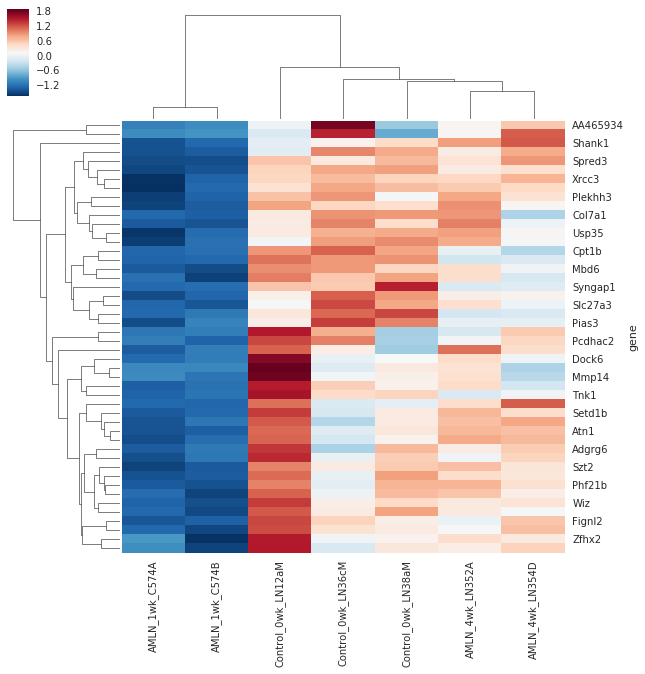

In [39]:
sns.set(font_scale=1)
sns.clustermap(tpm_mat_filt.loc[deseq_down_up, :].dropna(), z_score=0, cmap='RdBu_r')

In [41]:
print(', '.join(deseq_down_up))

Dtx3, Pias3, Gltscr1, Nlgn2, Cpt1b, Adgrl1, Atn1, Wiz, Mbd6, Fbrs, Wdfy1, Iqsec2, Spred3, Adgrg6, AA465934, Syngap1, Fignl2, Tnk1, Slfn9, Nckap5l, Dock6, Phf21b, Nudt16, Leng8, Cox6a2, Szt2, Plscr3, Xrcc3, Col11a2, Usp35, Mmp14, Slc27a3, Col7a1, Plekhh3, Gigyf1, Marco, Prr12, Zfp579, Slc22a17, Bcl9l, Ahdc1, Pcdhac2, Zfhx2, Setd1b, Sf3a2, Maml3, Pde1b, Kcp, Shank1


* Slc27a3 is a long chain fatty acid metabolic compount (acyl-CoA ligase) in mitochondrial beta oxidation gene, FA + CoA +ATP --> Acyl-CoA + AMP. Maybe 1 week KCs are turning off beta oxidation?
* Cpt1b rate controlling enzyme of long chain fatty acid beta oxidation, transports FA into mitochondria from cytoplasm
* Spred3 and Tnk1 both negatively regulate the MAPK pathway
* Setd1b is part of HMT complex that trimethylates H3 at Lys4
* Adgrg6 activated by type IV collagen
* Atn is transcriptional corepressor. Phf21b is a TF. Maml3 is a NOTCH coactivator
* FBRS induces fibroblasts proliferation
* Col11a2 and Col7a1 collagen compounds (obviously), mmp14 breaks down collagen
* Marco is classic KC gene - scavenger receptor for gram negative and gram positive bacteria
* Kcp inhibits TGFB signaling

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


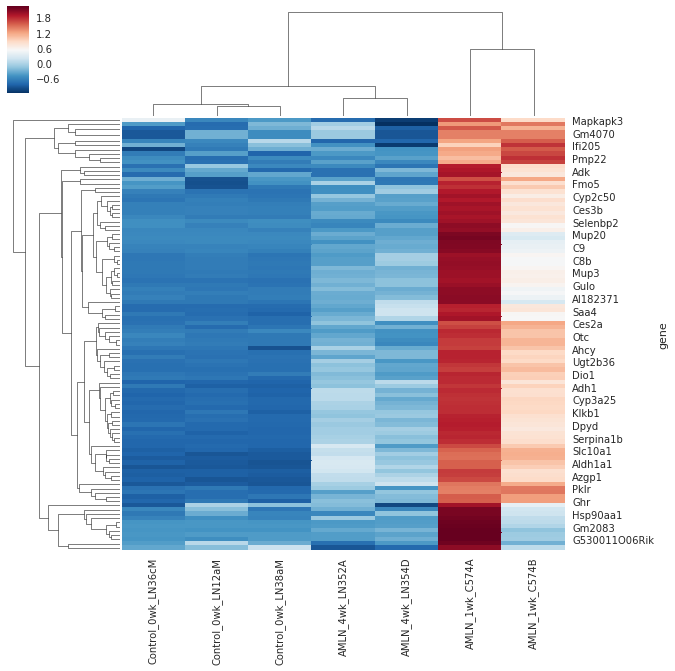

In [42]:
sns.set(font_scale=1)
sns.clustermap(tpm_mat_filt.loc[deseq_up_down, :].dropna(), z_score=0, cmap='RdBu_r')

In [43]:
', '.join(deseq_up_down)

'Slco1a1, Mup18, Ugt2b36, Cldn1, Pex13, Cyp2f2, Klkb1, Cyp2c67, Adh1, C9, Otc, Ugt2b34, Cxadr, Hsd3b5, Cyp2c70, Rdh7, Cyp3a25, Mup17, Mup20, Ugt3a2, Cyp2d9, Ahcy, Slc6a13, Adk, Hspe1, C8b, Cyp4a12a, Gdpd1, Ugt2b5, Hsd3b3, Tdo2, Serpina1c, Srd5a1, Slc22a30, Ifi211, Dio1, Cfhr1, Azgp1, Dhx40, Ccl2, Gm2083, Serpina1d, C8a, Slc10a1, Cps1, Rida, Ugt2a3, Sardh, Gm4070, Sult1d1, Ifi205, Mgst1, Nudt7, Mup11, Apoa2, Rpl29, Cyp2j5, Mup21, 2610507I01Rik, Gvin1, G530011O06Rik, Rbp4, Serpina1b, Pklr, Specc1, Dpyd, Myo1b, Mapkapk3, Saa4, Ifi209, Ces3b, Pon1, Serpina1a, Aadac, Serpina12, Cyp2c68, Baat, Aox3, Mup3, Cyp2a12, Hao1, Mup16, AI182371, Abcb11, Hsph1, Abcg8, Elovl2, Cyp4f14, Akr1c6, Mup14, Errfi1, Ifi208, Nat8f2, Ghr, Pmp22, Hsp90aa1, Egfr, Hspb8, Aldh6a1, Keg1, Selenbp2, Uox, Cfhr2, Scp2, Cyp2c50, Kmo, Fmo5, Slfn8, Thrsp, Ugt2b35, Serpina3k, Ces2c, Elovl3, Gm4788, Mup9, Ndrg2, Serpina4-ps1, Abcg5, Gulo, Abhd14b, Aldh1a1, Ces2a'

* Mapkapk3 activated by map kinase. Phosphorylates inflammatory genes
* Ifi205 activates NLRP3 inflammasome in resposne to
* Hsd3b5 is a steroid biosynthesis pathway enzyme, Cyp4a12 is a steroid oxidizer
* Cyp2c mice involved  in conjugation and creation of bile acids.
* Rdh7 is involved in retinol metabolism

# Purely fold change based comparisons
_____
There are some interesting groups that we can identify based on fold change...
* Unchanged between control and 1wk, up by > 2 fc from 1 wk to 4 wk. What is turned on as NASH diet progresses
* Up at 1 week, up more at 4 week
* Up at 1 week, then back down

In [32]:
tpm_avg = pd.DataFrame({'AMLN_4wk': tpm_mat_filt.loc[:, list(samplesDF.diet_time=='AMLN_4wk')].mean(axis=1),
                        'AMLN_1wk': tpm_mat_filt.loc[:, list(samplesDF.diet_time=='AMLN_1wk')].mean(axis=1),
                        'Control_0wk': tpm_mat_filt.loc[:, list(samplesDF.diet_time=='Control_0wk')].mean(axis=1)})

In [33]:
tpm_fc = pd.DataFrame({'fc_4wk': tpm_avg.AMLN_4wk / tpm_avg.Control_0wk,
                       'fc_4wk_vs_1wk': tpm_avg.AMLN_4wk / tpm_avg.AMLN_1wk,
                       'fc_1wk': tpm_avg.AMLN_1wk / tpm_avg.Control_0wk})

In [48]:
unchanged_up = (((tpm_fc.fc_1wk >= 0.5) & (tpm_fc.fc_1wk <= 1.5)) & (tpm_fc.fc_4wk_vs_1wk >= 2))
up_down = (((tpm_fc.fc_1wk >= 2)) & (tpm_fc.fc_4wk_vs_1wk <= 0.5))
down_up = (((tpm_fc.fc_1wk <= 0.5)) & (tpm_fc.fc_4wk_vs_1wk >= 2))

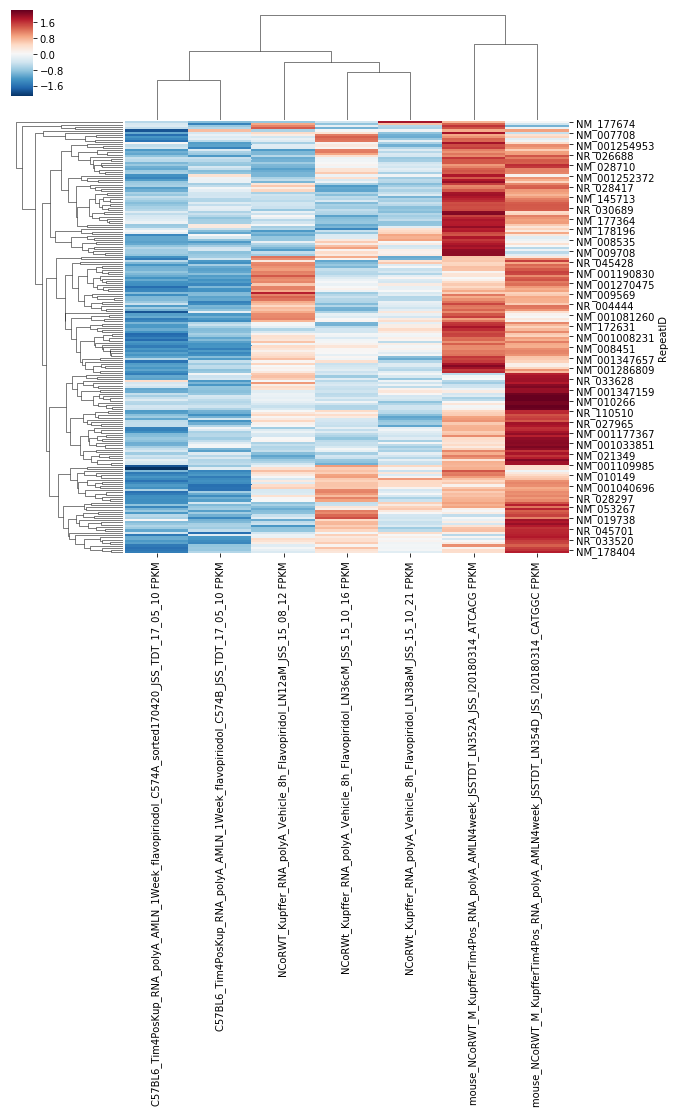

In [43]:
sns.clustermap(tpm_mat_filt.loc[unchanged_up, :], z_score=0, cmap='RdBu_r')

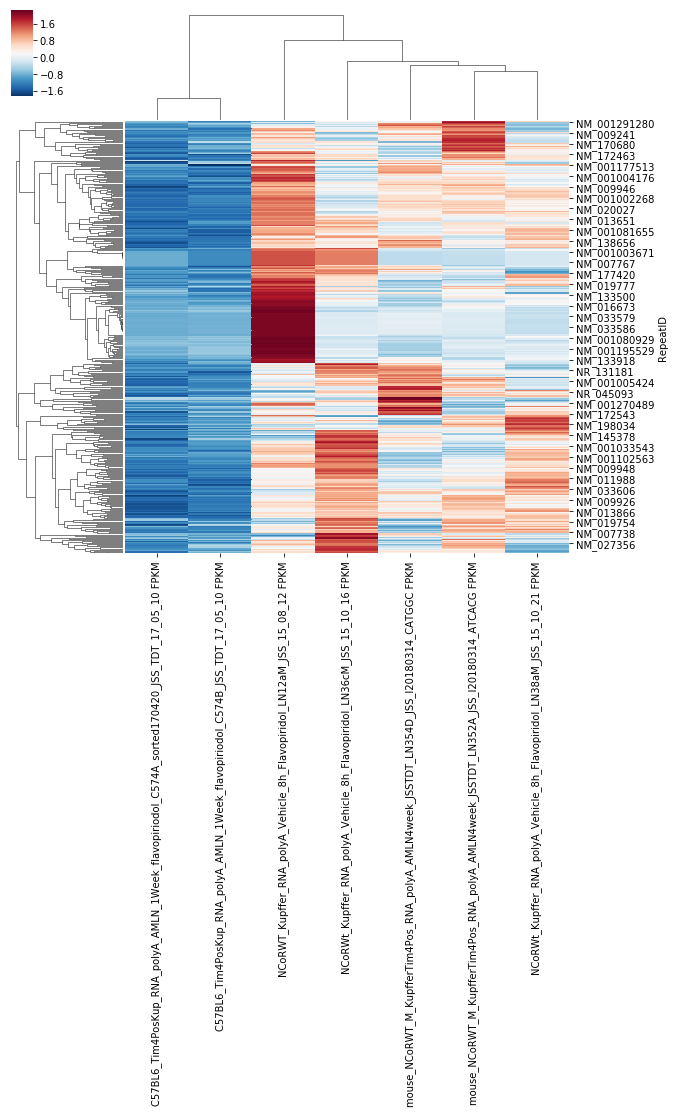

In [49]:
sns.clustermap(tpm_mat_filt.loc[down_up, :], z_score=0, cmap='RdBu_r')

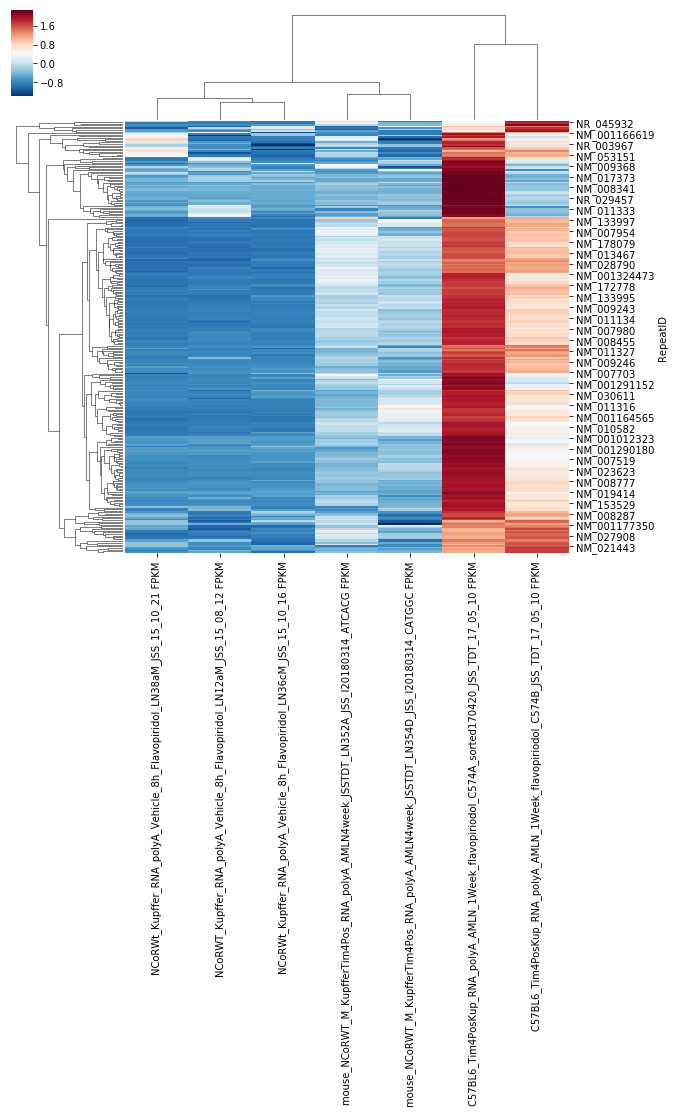

In [47]:
# There seems to be a strong pattern here, with genes activated at one week then turned off
# by the four week time-point (or significantly down)
# check the functional annotation...
sns.clustermap(tpm_mat_filt.loc[up_down, :], z_score=0, cmap='RdBu_r')

In [66]:
up_down_genes = mm10_refseq.loc[tpm_mat_filt.loc[up_down, :].index.tolist(), 'gene']

In [67]:
f = open(outdir + '/amln_1wk_up_4wk_down_genes.txt', 'w')
gene_list = '\n'.join(['refseqid'] +  up_down_genes.tolist())
f.write(gene_list)
f.close()

In [73]:
tpm_fc.loc[up_down, :].sort_values(by='fc_4wk_vs_1wk', ascending=True)

,fc_1wk,fc_4wk,fc_4wk_vs_1wk
RepeatID,,,
NM_019414,58.128454,0.424050,0.007295
NM_001200006,648.671569,15.886932,0.024491
NM_001134644,225.840824,6.419932,0.028427
NM_001164526,85.428637,3.126203,0.036594
NM_152811,139.740642,6.605799,0.047272
NM_010478,24.386606,1.355962,0.055603
NM_013654,4.967263,0.453137,0.091225
NM_001012306,49.359793,4.560252,0.092388
NM_031170,96.774614,9.367226,0.096794


### Timecourse plots

# Follow up question, what happens to the genes that are up by fc > 2 at 1 wk at 30 weeks?
To do this we have to first get the tim4 pos and tim4 neg gene expression levels set up

In [145]:
# define samples for both whole liver and kupffer
samples_c57_tim4 = {'kupffer':["NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN144B_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN146C_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN152B_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN144B_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN146D_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN146C_JSS_TDT_16_10_20",
                      "NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN152B_JSS_TDT_16_10_20"]}

In [146]:
# define sample data frame
samplesDF_c57_tim4 = pd.DataFrame([s for groups in samples_c57_tim4.values() for s in groups], columns = ['subject'])
samplesDF_c57_tim4['sample_type'] = ['liver' if 'WholeLiver' in name else 'kupffer' for name in samplesDF_c57_tim4.subject]
samplesDF_c57_tim4['path'] = [datapath[key] + s for key in datapath.keys() for s in samples_c57_tim4[key]]
samplesDF_c57_tim4['batch'] = pd.factorize(samplesDF_c57_tim4.subject\
             .str.replace('-','_')\
             .str.findall(r'(\d+_\d+_\d+)').str[0])[0]
samplesDF_c57_tim4['strain'] = [j.replace('-', '_').split('_')[0].lower() for j in samplesDF_c57_tim4.subject]
samplesDF_c57_tim4['strain'] = samplesDF_c57_tim4['strain'].replace('ncorwt', 'c57bl6')
samplesDF_c57_tim4['genotype'] = ['tim4pos' if 'Pos' in name else 'tim4neg' for name in samplesDF_c57_tim4.subject]
samplesDF_c57_tim4['exclusion'] = samplesDF_c57_tim4.subject.str.contains('|'.join(bad_samples.keys()),
                                                       flags=re.IGNORECASE)
samplesDF_c57_tim4['mouse'] = samplesDF_c57_tim4.subject.str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                     flags=re.IGNORECASE, expand=False)

In [147]:
# set analyses we want to do 
# No longer include genes. After discussion with Ty Troutman running analyzeRepeats with
# the 'condenseGenes' flag will collapse transcripts into one. Thus the ideal way to do
# RNA Seq for now is 'exons' - count only in exons, along with condenseGenes.
analyses = [('exons', False, None),
            ('exons', True, None),
            ('exons', False, 'rlog'), # ignore the rlog transform values for now
            ('exons', False, 'rpkm')]

In [148]:
# run annotate repeats with set of analysis options
for count_type, raw, norm in analyses:
    
    # generate file name
    filename = outdir + '/c57_tim4_rnaseq_matrix_condenseGenes_' + count_type
    if raw:
        filename += '_raw'
    if norm != None:
        filename += ('_'+ str(norm))
    filename += '.txt'
    
    # run annotate repeats
    if not os.path.isfile(filename):
        out, err = hbUtils.run_annotateRepeats(samplesDF_c57_tim4.path,
                countType=count_type, raw=raw, norm=norm, print_out=True)
        f = open(filename, 'w')
        f.write(out.decode('utf-8'))
        f.close()
        print(err.decode('utf-8'))

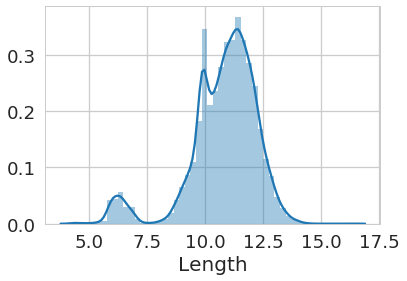

In [149]:
rpkm_c57_tim4 = pd.read_csv(outdir + '/c57_tim4_rnaseq_matrix_condenseGenes_exons_rpkm.txt', sep='\t')
sns.distplot(np.log2(rpkm_c57_tim4.Length + 1))

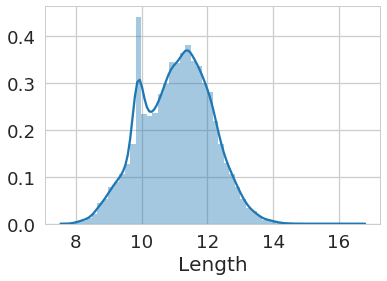

In [150]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm_c57_tim4 = rpkm_c57_tim4.loc[rpkm_c57_tim4.Length >= 250, :]
sns.distplot(np.log2(rpkm_c57_tim4.Length + 1))

In [151]:
tpm_mat_c57_tim4 = process_rpkm(rpkm_c57_tim4, conv_tpm=True)

### PCA

In [152]:
tpm_mat_c57_tim4.shape

(23192, 7)

In [153]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
tpm_std = StandardScaler().fit_transform(tpm_mat_c57_tim4)
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(tpm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF_c57_tim4.genotype])).reset_index()
tpm_pca_df['mouse'] = samplesDF_c57_tim4['mouse']

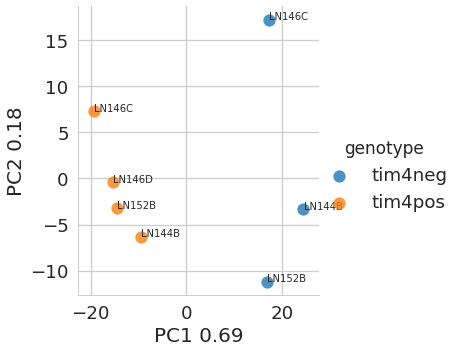

In [154]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='genotype',
                size=5, scatter_kws={'s': 150})
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.mouse, plt.gca())

Samples look pretty good, no obvious outliers

In [155]:
tpm_mat_c57_tim4_fc2_up = tpm_mat_c57_tim4.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_c57_tim4_fc2_dn = tpm_mat_c57_tim4.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [156]:
tpm_mat_fc2_up = tpm_mat.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_fc2_dn = tpm_mat.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [157]:
# merge and process fc up
fc2_up = pd.merge(tpm_mat_c57_tim4_fc2_up, tpm_mat_fc2_up,
                  left_index=True, right_index=True)
fc2_up = fc2_up.melt()

In [158]:
fc2_up['log2_rpkm'] = np.log2(fc2_up.value + 1)
fc2_up['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in fc2_up.variable]
fc2_up['diet'] = ['amln' if 'AMLN' in x else 'control' for x in fc2_up.variable]
fc2_up['tim4'] = ['tim4pos' if 'Pos' in x else 'tim4neg' for x in fc2_up.variable]
fc2_up['group'] = fc2_up.tim4 + '_' + fc2_up.diet

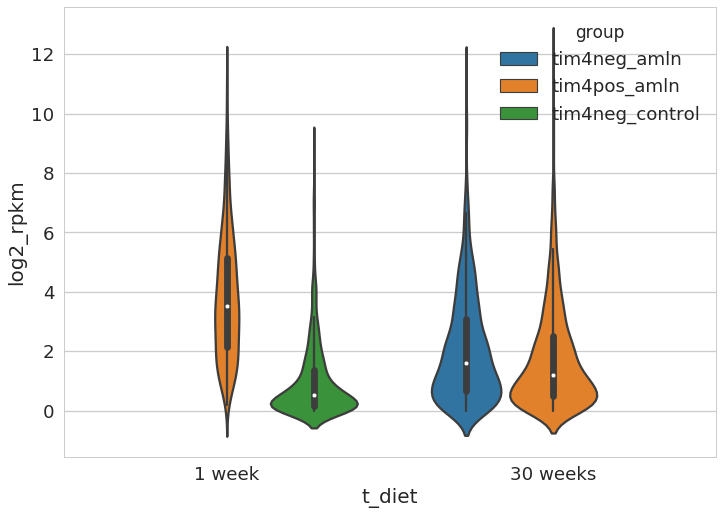

In [159]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='t_diet', y='log2_rpkm', hue='group',
               order= ['1 week', '30 weeks'], data=fc2_up)

In [160]:
from scipy import stats
print(stats.ranksums(
    fc2_up.loc[(fc2_up['t_diet'] == '1 week') & (fc2_up['group'] == 'tim4neg_control'), 'value'],
    fc2_up.loc[(fc2_up['t_diet'] == '1 week') & (fc2_up['group'] == 'tim4pos_amln'), 'value']))

print(stats.ranksums(
    fc2_up.loc[(fc2_up['t_diet'] == '30 weeks') & (fc2_up['group'] == 'tim4neg_amln'), 'value'],
    fc2_up.loc[(fc2_up['t_diet'] == '30 weeks') & (fc2_up['group'] == 'tim4pos_amln'), 'value']))

RanksumsResult(statistic=-34.059188169062303, pvalue=2.9674792719087292e-254)
RanksumsResult(statistic=5.6815987089929516, pvalue=1.3344146292720432e-08)


So it looks like the upregulated genes on 1 week of diet are also more highly expressed in timd4 negative Kupffer cells at 30 weeks

In [161]:
# merge and dnrocess fc dn
fc2_dn = pd.merge(tpm_mat_c57_tim4_fc2_dn, tpm_mat_fc2_dn,
                  left_index=True, right_index=True)
fc2_dn = fc2_dn.melt()

In [162]:
fc2_dn['log2_rpkm'] = np.log2(fc2_dn.value + 1)
fc2_dn['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in fc2_dn.variable]
fc2_dn['diet'] = ['amln' if 'AMLN' in x else 'control' for x in fc2_dn.variable]
fc2_dn['tim4'] = ['tim4pos' if 'Pos' in x else 'tim4neg' for x in fc2_dn.variable]
fc2_dn['group'] = fc2_dn.tim4 + '_' + fc2_dn.diet

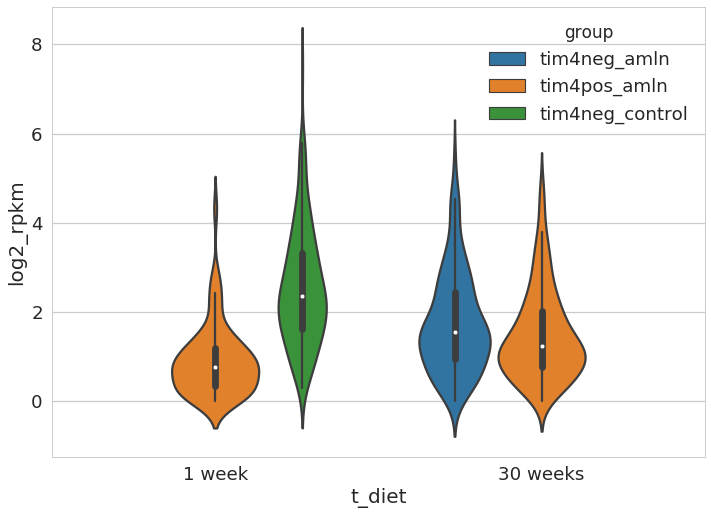

In [163]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='t_diet', y='log2_rpkm', hue='group',
               order= ['1 week', '30 weeks'], data=fc2_dn)

In [164]:
from scipy import stats
print(stats.ranksums(
    fc2_dn.loc[(fc2_dn['t_diet'] == '1 week') & (fc2_dn['group'] == 'tim4neg_control'), 'value'],
    fc2_dn.loc[(fc2_dn['t_diet'] == '1 week') & (fc2_dn['group'] == 'tim4pos_amln'), 'value']))

print(stats.ranksums(
    fc2_dn.loc[(fc2_dn['t_diet'] == '30 weeks') & (fc2_dn['group'] == 'tim4neg_amln'), 'value'],
    fc2_dn.loc[(fc2_dn['t_diet'] == '30 weeks') & (fc2_dn['group'] == 'tim4pos_amln'), 'value']))

RanksumsResult(statistic=11.697519458045209, pvalue=1.3123372408818343e-31)
RanksumsResult(statistic=2.782099118418218, pvalue=0.00540085425921852)


This is showing that the genes that are down in the 1 week NASH model are also slightly increased in tim4negative cells

Its interesting that both of these gene sets are up in 30 week tim4 negative kupffer cells compared to tim4 positive kupffer cells

# Lets compare the kupffer cell specific gene list...

In [165]:
# read in Jason's 150 Kupffer cell specific genes
file = open('/home/h1bennet/liverStrains/data/mouse/KC_Specific_Genes150.txt')
kc_spec_genes = file.read().split('\n')

In [166]:
# get the index of values with the kc specific genes
kc_spec_index = counts_df['Annotation/Divergence'].str.match(
    '|'.join([s + '\|' for s in kc_spec_genes]), flags=re.IGNORECASE)

In [167]:
# re-index the tpms with the KC specific genes
tpm_mat_c57_tim4_kupffer = tpm_mat_c57_tim4.reindex(list(counts_df.loc[kc_spec_index, :].index))
tpm_mat_kupffer = tpm_mat.reindex(list(counts_df.loc[kc_spec_index, :].index))

In [168]:
# merge and dnrocess fc dn
kupffer_genes = pd.merge(tpm_mat_c57_tim4_kupffer, tpm_mat_kupffer,
                  left_index=True, right_index=True)

# melt
kupffer_genes = kupffer_genes.melt()

In [169]:
# categorize samples
kupffer_genes['log2_rpkm'] = np.log2(kupffer_genes.value + 1)
kupffer_genes['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in kupffer_genes.variable]
kupffer_genes['diet'] = ['amln' if 'AMLN' in x else 'control' for x in kupffer_genes.variable]
kupffer_genes['tim4'] = ['tim4pos' if 'Pos' in x else 'tim4neg' for x in kupffer_genes.variable]
kupffer_genes['group'] = kupffer_genes.tim4 + '_' + kupffer_genes.diet

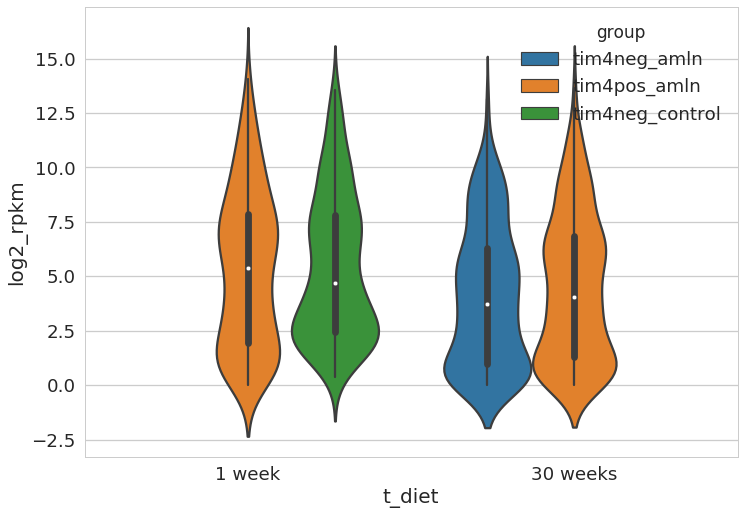

In [170]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='t_diet', y='log2_rpkm', hue='group',
               order= ['1 week', '30 weeks'], data=kupffer_genes)

In [171]:
from scipy import stats
print(stats.ranksums(
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '1 week') & (kupffer_genes['group'] == 'tim4neg_control'), 'value'],
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '1 week') & (kupffer_genes['group'] == 'tim4pos_amln'), 'value']))

print(stats.ranksums(
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '30 weeks') & (kupffer_genes['group'] == 'tim4neg_amln'), 'value'],
    kupffer_genes.loc[(kupffer_genes['t_diet'] == '30 weeks') & (kupffer_genes['group'] == 'tim4pos_amln'), 'value']))


RanksumsResult(statistic=0.36001373591229774, pvalue=0.71883686158284976)
RanksumsResult(statistic=-1.7738682192751933, pvalue=0.076084950679877278)


# One question that might be interesting: are the gene expression profiles for genes that are significantly different at 1 wk more similar to the expression profiles in balb/aj at 30 wks compared to ncorwt?

In [172]:
# load in RPKM from all strains experiment
rpkm_strains = pd.read_csv(
    '/home/h1bennet/liverStrains/results/180111_RNA_Seq/rnaseq_matrix_condenseGenes_exons_rpkm.txt',
    sep='\t')
# subset kupffer cell data
rpkm_strains = hbUtils.df_col_subset(rpkm_strains, 'kupffer')
# clean up index column
rpkm_strains.columns.values[0] = 'Transcript/RepeatID'
rpkm_strains = rpkm_strains.set_index('Transcript/RepeatID')
# convert to tpm
tpm_strains = rpkm_strains

In [173]:
tpm_mat_strains_fc2_up = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_strains_fc2_dn = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [174]:
# process fc2 up
strains_fc2_up = tpm_mat_strains_fc2_up.melt()

In [175]:
strains_fc2_up['log2_rpkm'] = np.log2(strains_fc2_up.value + 1)
strains_fc2_up['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in strains_fc2_up.variable]
strains_fc2_up['diet'] = ['amln' if 'AMLN' in x else 'control' for x in strains_fc2_up.variable]
strains_fc2_up['strain'] = ['balb' if 'balb' in x else 'aj' if 'aj' in x else 'c57bl6' for x in strains_fc2_up.variable]
strains_fc2_up['group'] = strains_fc2_up.strain + '_' + strains_fc2_up.diet

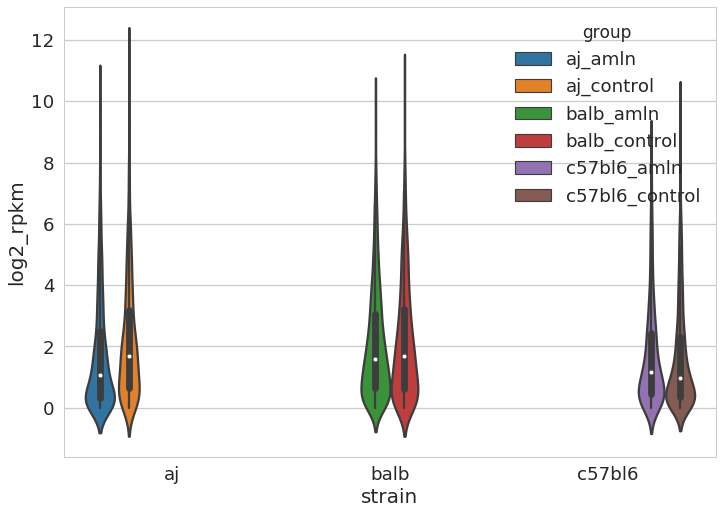

In [176]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='strain', y='log2_rpkm', hue='group', data=strains_fc2_up)

In [177]:
tpm_mat_strains_fc2_dn = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange >= 2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')
tpm_mat_strains_fc2_dn = tpm_strains.reindex(
    deseq.loc[(deseq.log2FoldChange <= -2) & (deseq.padj <= 0.01), 'Unnamed: 0'],
    axis=0).dropna(axis=0, how='any')

In [178]:
# process fc2 up
strains_fc2_dn = tpm_mat_strains_fc2_dn.melt()

In [179]:
strains_fc2_dn['log2_rpkm'] = np.log2(strains_fc2_dn.value + 1)
strains_fc2_dn['t_diet'] = ['30 weeks' if '30' in x else '1 week' for x in strains_fc2_dn.variable]
strains_fc2_dn['diet'] = ['amln' if 'AMLN' in x else 'control' for x in strains_fc2_dn.variable]
strains_fc2_dn['strain'] = ['balb' if 'balb' in x else 'aj' if 'aj' in x else 'c57bl6' for x in strains_fc2_dn.variable]
strains_fc2_dn['group'] = strains_fc2_dn.strain + '_' + strains_fc2_dn.diet

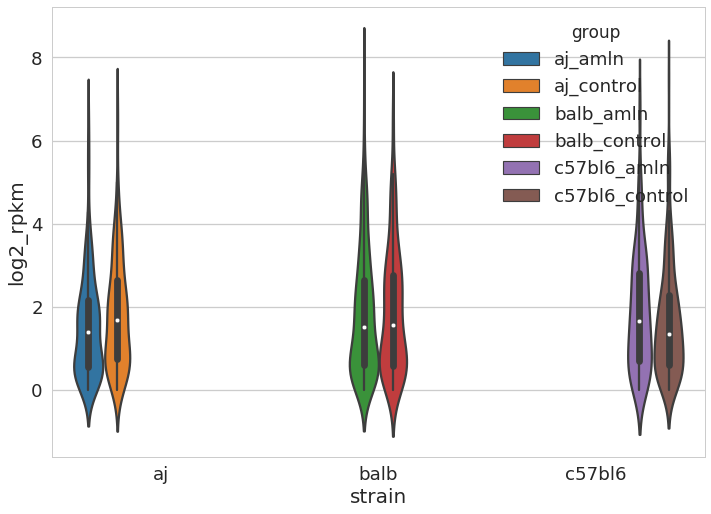

In [180]:
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.violinplot(x='strain', y='log2_rpkm', hue='group', data=strains_fc2_dn)

### Different way to ask similar question - heirarchical clustering on 1000 most variable genes in the dataset at 1 week and then at 30 weeks, how different does the data look?

In [211]:
var_tpm = tpm_mat.std(axis=1).sort_values(ascending=False)
var_tpm_top1000 = var_tpm[:1000]

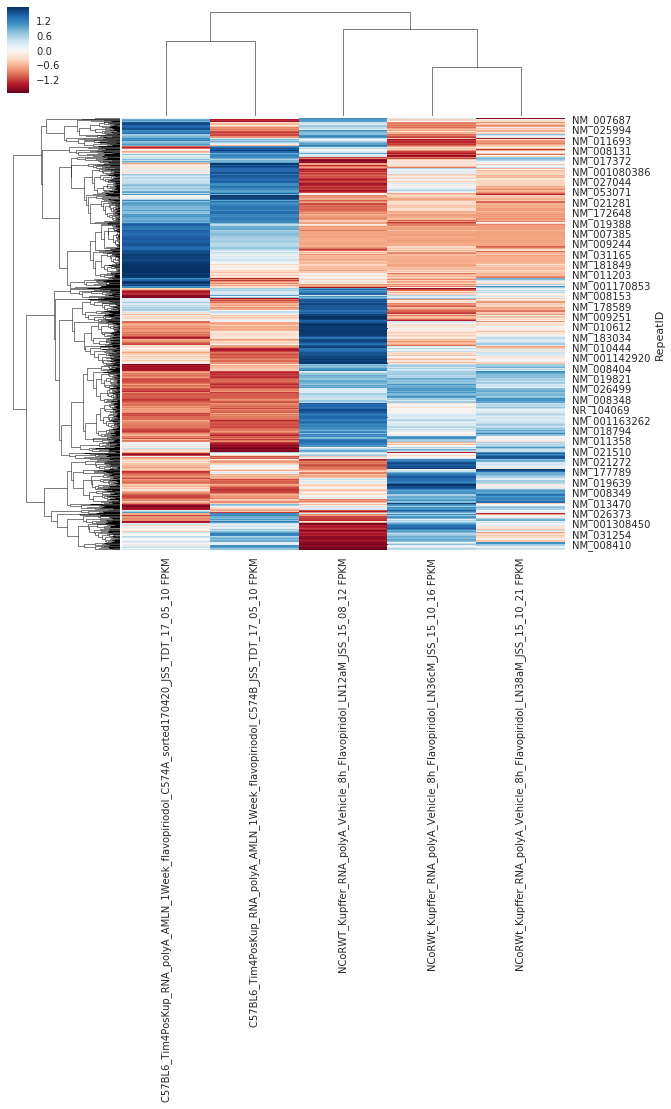

In [216]:
sns.set(font_scale=1)
sns.clustermap(tpm_mat.loc[list(var_tpm_top1000.index), :], z_score=0, cmap='RdBu')

In [234]:
# why would this be pulling out so few genes?
tpm_mat_c57_tim4.reindex(list(var_tpm_top1000.index)).dropna().describe()

,NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN144B_JSS_TDT_16_10_20 FPKM,NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN146C_JSS_TDT_16_10_20 FPKM,NCoRWT_KupfferTim4Neg_RNA_polyA_AMLNDiet_30week_LN152B_JSS_TDT_16_10_20 FPKM,NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN144B_JSS_TDT_16_10_20 FPKM,NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN146D_JSS_TDT_16_10_20 FPKM,NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN146C_JSS_TDT_16_10_20 FPKM,NCoRWT_KupfferTim4Pos_RNA_polyA_AMLNDiet_30week_LN152B_JSS_TDT_16_10_20 FPKM
count,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000,964.000000
mean,606.039619,637.238135,595.150874,626.530984,636.813676,639.858875,630.318559
std,2169.494179,2507.006826,2217.724964,2475.410359,2456.386540,2297.204542,2541.431295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.842843,100.685415,116.083402,113.140095,115.715497,114.007138,111.455101
50%,217.875847,202.472185,221.025277,221.456396,222.723898,221.115692,221.342849
75%,433.410541,429.794851,432.588003,439.516221,439.815776,456.813065,437.795233
max,44106.260807,55387.378857,48834.063966,60557.746584,61168.618854,55130.283705,63919.686055


ValueError: The condensed distance matrix must contain only finite values.

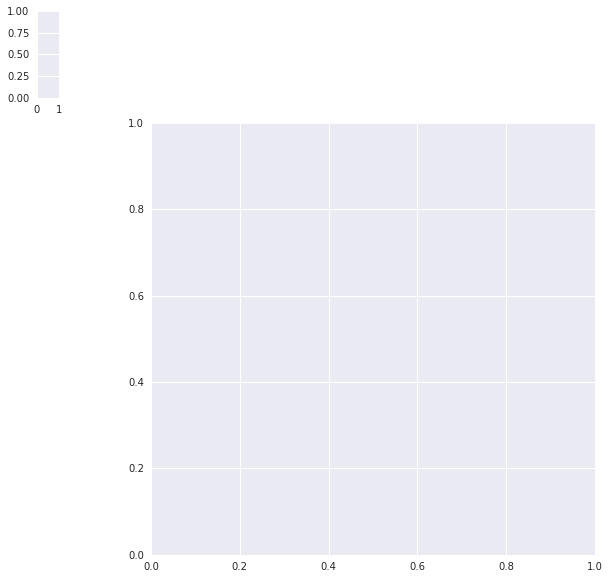

In [270]:
sns.clustermap(tpm_mat_c57_tim4.reindex(list(var_tpm_top1000.index)).dropna().apply(pd.to_numeric), z_score=0, cmap='RdBu')

In [313]:
tpm_mat_c57_tim4_1k = tpm_mat_c57_tim4.reindex(list(var_tpm_top1000.index)).dropna()

In [314]:
tpm_mat_c57_tim4_1k.shape

(964, 7)

In [311]:
tpm_mat_c57_tim4_1k_z = (tpm_mat_c57_tim4_1k.subtract(tpm_mat_c57_tim4_1k.mean(axis=1), axis=0)).divide(tpm_mat_c57_tim4_1k.std(axis=1), axis=0)

ValueError: The condensed distance matrix must contain only finite values.

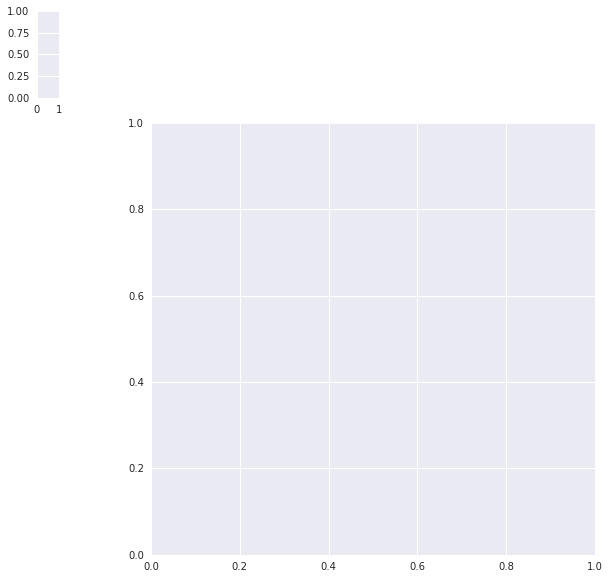

In [312]:
sns.clustermap(tpm_mat_c57_tim4_1k_z, metric='euclidean')

In [303]:
from scipy.spatial import distance

In [305]:
distance.pdist(tpm_mat_c57_tim4_1k_z, 'euclidean')

array([ 3.26258075,  3.88002822,  1.80984552, ...,  3.19771985,
        2.10503196,  3.20907595])

In [246]:
tpm_mat_c57_tim4.reindex(list(var_tpm_top1000.index)).dropna().T.describe()

RepeatID,NM_001305844,NM_021278,NM_007393,NM_009690,NM_001110009,NM_010545,NM_007995,NM_007572,NM_016751,NM_017372,...,NM_133807,NM_019861,NM_026542,NM_001159367,NM_172648,NM_153551,NM_001309799,NM_025344,NM_007645,NM_028057
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,55586.291261,10747.406548,16709.270155,9810.204824,2026.066034,26900.841269,571.405840,4951.112427,2862.057261,11072.292893,...,144.251480,87.261162,189.220285,73.074472,17.618092,83.648762,120.982146,425.644279,247.087070,124.494073
std,7105.800446,1427.040989,3134.834506,2460.774812,1017.367382,5690.108613,309.124819,1038.700312,1301.738635,1441.874942,...,9.639633,23.227466,10.646555,22.421777,5.008676,9.341444,16.118624,66.200293,22.152999,7.915954
min,44106.260807,8196.058030,14311.761286,5868.219162,794.698325,19022.816845,301.624546,3275.755390,1432.455531,9717.948818,...,130.629686,60.817945,172.311386,53.153494,11.119257,73.792212,98.299146,358.403463,224.620897,111.795128
25%,51982.173835,10191.272608,14964.953574,8326.858076,1058.938133,23318.016321,330.025134,4283.379577,1613.678936,10094.263732,...,138.800125,71.662467,182.634707,57.343650,15.006984,77.706173,108.147551,368.084404,230.329833,121.452211
50%,55387.378857,10809.146408,15424.129788,10798.666030,2515.784936,25137.687010,469.692961,5475.045461,3054.609230,10703.162568,...,143.635494,82.553258,190.517050,64.979656,16.568179,83.641517,127.767356,404.447554,234.666622,124.875839
75%,60863.182719,11787.577963,17119.819738,11172.626297,2829.822835,31314.645871,740.622695,5676.721651,3952.875536,11535.147559,...,148.937874,97.467447,196.939086,84.208391,19.331433,85.215924,131.899281,482.620853,264.839956,126.934744
max,63919.686055,12268.940261,23059.453387,13005.579832,3094.457044,34880.060643,1087.227715,5986.783681,4414.227122,13826.116286,...,160.019179,129.197099,202.565976,110.284074,26.962371,102.263414,140.714855,515.248427,279.982396,138.013635


### Next we want to annotate the browser track we created with LXR/SREBP peaks from Nathan's paper - main question here is if there are LXR, SREBP, PPAR peaks nearby the genes that are turned ON at 1 week on AMLN diet

make hubs

makeMultiWigHub.pl hrb_bmdm_lxr mm10 -d /data/mm10/BMDM/ChIP/LXR/*WT* -url http://homer.ucsd.edu/hubs/ -webdir /homer_data/www/html/hubs

makeMultiWigHub.pl hrb_thiomac_lxr_timecourse mm10 -force -d /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15 /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_KLA-1h_NJS_13-04-15 /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_KLA-6h_NJS_13-04-15 /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_KLA-24h_NJS_13-04-15 /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx-Input_NJS_13-04-15 /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_KLA-24h-Input_NJS_13-04-15 -url http://homer.ucsd.edu/hubs/ -webdir /homer_data/www/html/hubs

makeMultiWigHub.pl hrb_thiomac_ppar mm10 -force -d /data/mm10/ThioMac/ChIP/PPAR/C57Bl6_ThioMac_ChIP_PPARg_notx_NJS_11-05-25 /data/mm10/ThioMac/ChIP/PPAR/C57Bl6_ThioMac_ChIP_PPARg_notx_NJS2_11-05-25 /data/mm10/ThioMac/ChIP/PPAR/C57Bl6_Thiomac_ChIP_PPARg_Veh_NJS_11-04-08 /data/mm10/ThioMac/ChIP/PPAR/C57Bl6_Thiomac_ChIP_PPARg_Veh_NJS_11-04-14 /data/mm10/ThioMac/ChIP/PPAR/C57Bl6_ThioMac_ChIP_Input_NJS_11-05-25 /data/mm10/ThioMac/ChIP/PPAR/C57Bl6_ThioMac_ChIP_Input_NJS2_11-05-25 -url http://homer.ucsd.edu/hubs/ -webdir /homer_data/www/html/hubs

makeMultiWigHub.pl hrb_thiomac_srebp_timecourse mm10 -force -d /data/mm10/ThioMac/ChIP/SREBP/C57BL6_ThioMac_ChIP_SREBP_notx_NJS_13-10-23 /data/mm10/ThioMac/ChIP/SREBP/C57BL6_ThioMac_ChIP_SREBP_kla1h_NJS_13-10-23 /data/mm10/ThioMac/ChIP/SREBP/C57BL6_ThioMac_ChIP_SREBP_kla6h_NJS_13-10-23 /data/mm10/ThioMac/ChIP/SREBP/C57BL6_ThioMac_ChIP_SREBP_kla24h_NJS_13-10-23 /data/mm10/ThioMac/ChIP/SREBP/C57BL6_ThioMac_ChIP_SREBP_input-notx_NJS_13-10-23 -url http://homer.ucsd.edu/hubs/ -webdir /homer_data/www/html/hubs

call peaks

for dir in /data/mm10/BMDM/ChIP/LXR/*WT*; do dirname=${dir##*/}; findPeaks $dir -o /home/h1bennet/liverStrains/results/180205_RNA_1wk/$dirname.peaks.txt -style factor; done

for dir in /data/mm10/ThioMac/ChIP/SREBP/*; do dirname=${dir##*/}; findPeaks $dir -o /home/h1bennet/liverStrains/results/180205_RNA_1wk/$dirname.peaks.txt -style factor; done

for dir in /data/mm10/ThioMac/ChIP/LXR/*; do dirname=${dir##*/}; findPeaks $dir -o /home/h1bennet/liverStrains/results/180205_RNA_1wk/peakfiles/$dirname.peaks.txt -style factor; done

for dir in /data/mm10/ThioMac/ChIP/PPAR/C57Bl6*; do dirname=${dir##*/}; findPeaks $dir -o /home/h1bennet/liverStrains/results/180205_RNA_1wk/$dirname.peaks.txt -style factor; done

convert to bed files

### Lets see how many genes within our pool overlap with pathways we are interested in...

In [81]:
def intersect(list1, list2):
    return list(set(list1) & set(list2))

def gene_list_fisher_exact(target_list, pathway_list, background_list):
    '''This script runs a fishers exact test for a given gene pathway
    Target_list: list of string gene IDs
    pathway_list: list of string gene IDs
    background_list: list of strings of gene IDs for entire assay
    Target list and pathway list can be any ID as long as they match'''
    from scipy.stats import fisher_exact
    path_target = len(set(pathway_list).intersection(target_list))
    path_non_target = len(set(pathway_list).difference(target_list))
    non_path_target = len(set(target_list).difference(pathway_list))
    non_path_non_target = len(set(background_list).difference(target_list).difference(pathway_list))
    df_out = pd.DataFrame([[path_target, non_path_target], [path_non_target, non_path_non_target]],
                          index=['in target list', 'not in target list'],
                          columns=['in pathway', 'not in pathway'])
    print(df_out)
    return fisher_exact([[path_target, non_path_target], [path_non_target, non_path_non_target]])

Define gene list of significantly altered genes

In [82]:
# select genes with padj <= 0.01 and FC > 2
idx_fc2_up_p01 = ((deseq_anno.padj <= 0.01) & ((deseq_anno.log2FoldChange) >= 2))
idx_fc2_dn_p01 = ((deseq_anno.padj <= 0.01) & ((deseq_anno.log2FoldChange) <= -2))

In [83]:
deseq_anno.loc[idx_fc2_up_p01, :].head()

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr,start,end,strand,Length,Copies,Annotation/Divergence,gene
0,NM_001305585,1375.746589,5.224745,0.228069,22.908651,3.809563e-116,5.508629e-112,chr1,171221564,171226379,+,859.0,1,Apoa2|Alp-2|Apo-AII|ApoA-II|ApoAII|Apoa-2|Hdl-...,Apoa2
1,NM_009244,1400.210270,6.634121,0.306582,21.638991,7.717348e-104,5.579643e-100,chr12,103728156,103738189,-,1418.0,1,Serpina1b|D12Ucla2|Dom2|PI2|Spi1-2|-|12 E|12 5...,Serpina1b
2,NM_009692,2306.523725,6.675785,0.324339,20.582729,3.919818e-94,1.889352e-90,chr9,46228630,46230469,+,982.0,1,Apoa1|Alp-1|Apoa-1|Brp-14|Ltw-1|Lvtw-1|Sep-1|S...,Apoa1
3,NM_001159487,866.053013,6.693674,0.329004,20.345252,5.114876e-92,1.849028e-88,chr19,38116620,38125321,-,1235.0,1,Rbp4|Rbp-4|-|19 C2|19 32.75 cM|protein-coding,Rbp4
4,NM_009246,814.967764,6.548752,0.335902,19.495995,1.187224e-84,3.433452e-81,chr12,103763587,103773633,-,1435.0,1,Serpina1d|AI118301|Dom4|PI4|Spi1-4|-|12 E|12 5...,Serpina1d


In [84]:
# write gene names to a list
deseq_anno.loc[idx_fc2_up_p01, 'Unnamed: 0'].to_csv(outdir + 'deseq_1wkNASH_fc2up_p01.txt', sep='\t', index=False)
deseq_anno.loc[idx_fc2_dn_p01, 'Unnamed: 0'].to_csv(outdir + 'deseq_1wkNASH_fc2dn_p01.txt', sep='\t', index=False)
deseq_anno.loc[idx_fc2_dn_p01 | idx_fc2_up_p01, 'Unnamed: 0'].to_csv(outdir + 'deseq_1wkNASH_fc2_p01.txt', sep='\t', index=False)

### Investigate a couple of interesting gene sets 

** Jason KC Spec Genes **

In [101]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_up_p01, 'gene'],
                        go_lipid_trans_alt.Gene,
                        kc_spec_genes)

                    in pathway  not in pathway
in target list              48             560
not in target list         274             136


(0.042544316996871744, 1.422569572906702e-91)

In [102]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_dn_p01, 'gene'],
                        go_lipid_trans_alt.Gene,
                        kc_spec_genes)

                    in pathway  not in pathway
in target list               0              86
not in target list         322             144


(0.0, 2.3740721320218899e-38)

**GO:006869 Lipid Transport**

In [85]:
go_lipid_trans = pd.DataFrame(hbUtils.pull_go_terms('0006869', 10090, product_type='protein'),
                              columns=['UniprotID', 'Gene', 'Organism'])

In [86]:
go_lipid_trans_alt = pd.read_csv('/home/h1bennet/data/ontologies/mouse/180214_0006869_LipidTransport.txt', sep='\t')

In [87]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_up_p01, 'gene'],
                        go_lipid_trans_alt.Gene,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list              48             560
not in target list         274           22313


(6.9800834202294055, 1.2487184558027756e-22)

In [88]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_dn_p01, 'gene'],
                        go_lipid_trans_alt.Gene,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list               0              86
not in target list         322           22787


(0.0, 0.63561953796781667)

**GO:0008203 Cholesterol Metabolic Process**

In [94]:
f = open('/home/h1bennet/data/ontologies/mouse/180308_0008203_CholesterolMetabolicProcess.txt')    
go_chol_met = f.read().split('\n')

In [98]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_up_p01, 'gene'],
                        go_chol_met,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list              24             584
not in target list          95           22494


(9.730641672674837, 5.9943840709258508e-15)

In [100]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_dn_p01, 'gene'],
                        go_chol_met,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list               0              86
not in target list         119           22992


(0.0, 1.0)

**GO:0016126 Sterol Biosythetic Process**

In [104]:
f = open('/home/h1bennet/data/ontologies/mouse/180308_0016126_SterolBiosytheticProcess.txt')    
go_sterol_biosyn = f.read().split('\n')

In [105]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_up_p01, 'gene'],
                        go_sterol_biosyn,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list               9             599
not in target list          44           22544


(7.6982850204886937, 8.7172639075723376e-06)

In [106]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_dn_p01, 'gene'],
                        go_sterol_biosyn,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list               0              86
not in target list          53           23057


(0.0, 1.0)

**GO:0006954 Inflammatory Response **

In [107]:
f = open('/home/h1bennet/data/ontologies/mouse/180309_0006954_InflammatoryResponse.txt')    
go_inflammatory_response = f.read().split('\n')

In [108]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_up_p01, 'gene'],
                        go_inflammatory_response,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list              39             569
not in target list         618           21982


(2.4379852236081012, 2.4510502668235671e-06)

In [110]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_dn_p01, 'gene'],
                        go_inflammatory_response,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list               8              78
not in target list         649           22473


(3.5514993481095174, 0.0030179525351434777)

In [115]:
set(go_inflammatory_response).intersection(deseq_anno.loc[idx_fc2_up_p01, 'gene'])

{'Agt',
 'Agtr1a',
 'Ahcy',
 'Ahsg',
 'Apoa1',
 'C3',
 'Ccl12',
 'Ccl8',
 'Ccl9',
 'Crp',
 'Cxcl1',
 'Cxcl2',
 'Egfr',
 'Ephx2',
 'F12',
 'F2',
 'Fndc4',
 'Hamp',
 'Hc',
 'Hp',
 'Itih4',
 'Klkb1',
 'Kng1',
 'Nlrp6',
 'Nr1h4',
 'Orm1',
 'Ppara',
 'Proc',
 'Rarres2',
 'Saa1',
 'Saa2',
 'Saa4',
 'Sdc1',
 'Serpina1b',
 'Serpina3n',
 'Serpinf1',
 'Serpinf2',
 'Serping1',
 'Vnn1'}

** Jason's LXR Dependent Genes **

In [77]:
f = open('/home/h1bennet/data/gene_lists/mouse/LXRDKODown2foldGenes.txt', 'r')
lxrdko_fc2_dn = f.read().replace('\t', '').split('\n')

f = open('/home/h1bennet/data/gene_lists/mouse/LXRDKOUp2foldGenes.txt', 'r')
lxrdko_fc2_up = f.read().replace('\t', '').split('\n')

In [78]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_up_p01, 'gene'],
                        lxrdko_fc2_up,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list              83             525
not in target list         787           21802


(4.3796599503842195, 9.9184819809677111e-25)

In [79]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_up_p01, 'gene'],
                        lxrdko_fc2_dn,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list               3             605
not in target list         494           22097


(0.22180546726001271, 0.0015720206606928645)

The above results is actually counter-intuitive because we would expect LXR activation at 1 week on diet to induce outward cholesterol transport, however it seems like the genes that are turned on by 1 week of diet are also turned on by an LXR knockout.

** Downregulated on 1 week diet **

In [80]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_dn_p01, 'gene'],
                        lxrdko_fc2_dn,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list               1              85
not in target list         496           22617


(0.53645635673624292, 1.0)

In [81]:
gene_list_fisher_exact(deseq_anno.loc[idx_fc2_dn_p01, 'gene'],
                        lxrdko_fc2_up,
                        deseq_anno.gene)

                    in pathway  not in pathway
in target list              18              68
not in target list         852           22259


(6.9155965202982603, 2.5045913588991816e-09)

### Per Nathan's suggestion we should call ATAC peaks in Kupffer cells then overlap with LXR peaks or LXR motifs to try and get an idea of the LXR cistrome in Kupffer cells at 1 week. Then use Verena's nearby peaks script to figure out which of these peaks are near differentially regulated genes

### Call atac peaks

perl /home/h1bennet/liverStrains/bin/run_IDR.pl -tag_dirs /home/h1bennet/Kupffer/ATAC/NCoRWT_Kupffer_ATAC_Vehicle_8h_Flavopiridol_NNaF_JSS_15_08_11 /home/h1bennet/Kupffer/ATAC/NCoRWT_Kupffer_ATAC_Vehicle_8h_Flavopiridol_LN12aM_JSS_15_08_12 -output_dir /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/ -method atac

### call LXR peaks in different LXR ChIP samples

**BMDM**

findPeaks /data/mm10/BMDM/ChIP/LXR/BMDM-LXR-WT_notx-13-04-15 -style factor -o /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/BMDM-LXR-WT_notx-13-04-15.txt -i /data/mm10/BMDM/ChIP/LXR/BMDM-LXR-WT_notx-Input-13-04-15

findPeaks /data/mm10/BMDM/ChIP/LXR/BMDM-LXR-WT_GW3965-1h-13-04-15 -style factor -o /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/BMDM-LXR-WT_GW3965-1h-13-04-15.txt -i /data/mm10/BMDM/ChIP/LXR/BMDM-LXR-WT_notx-Input-13-04-15

**Thio**

findPeaks /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15 -style factor -o /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15.txt -i /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx-Input_NJS_13-04-15

### annotate ATAC peaks with LXR motifs

annotatePeaks.pl /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile.txt mm10 -noann -nogene -m /bioinformatics/bioinformatics/homer/motifs/lxre.motif > /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile_lxr_motifs_anno.txt

take a look at the peak file

sort -r optimal_peakfile_lxr_motifs_anno.txt -k 10,10 | head

### merge ATAC peaks with LXR peaks in BMDM/Thios

mergePeaks -d given /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile.txt /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15.peaks.txt > /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile_ThioMac_ChIP_LXR_notx_merge.txt

mergePeaks -d given /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile.txt /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/BMDM-LXR-WT_notx-13-04-15.txt > /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile_BMDM_ChIP_LXR_notx_merge.txt

mergePeaks -d given /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile.txt /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/BMDM-LXR-WT_GW3965-1h-13-04-15.txt > /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile_ThioMac_ChIP_LXR_GW3965_1h_merge.txt

cp /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile.txt /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/
cd /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/

mergePeaks -d given optimal_peakfile.txt C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15.txt -prefix thio_notx

mergePeaks -d given optimal_peakfile.txt BMDM-LXR-WT_notx-13-04-15.txt -prefix bmdm_notx

mergePeaks -d given optimal_peakfile.txt BMDM-LXR-WT_GW3965-1h-13-04-15.txt -prefix bmdm_gw3965_1hr

### We now have four peak files we can assess for their location near differentially expressed genes using Verena's script

perl /home/h1bennet/liverStrains/bin/get_closest_peak_to_genes.pl /home/h1bennet/liverStrains/results/180205_RNA_1wk/deseq_1wkNASH_fc2_p01.txt /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/bmdm_gw3965_1hr_optimal_peakfile.txt_BMDM-LXR-WT_GW3965-1h-13-04-15.txt mm10 -range 10kb > /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/bmdm_gw3965_1hr_optimal_peakfile.txt_BMDM-LXR-WT_GW3965-1h-13-04-15_1wkNASH_fc2_nearest_genes.txt

perl /home/h1bennet/liverStrains/bin/get_closest_peak_to_genes.pl /home/h1bennet/liverStrains/results/180205_RNA_1wk/deseq_1wkNASH_fc2_p01.txt /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/bmdm_notx_optimal_peakfile.txt_BMDM-LXR-WT_notx-13-04-15.txt mm10 -range 10kb > /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/bmdm_notx_optimal_peakfile.txt_BMDM-LXR-WT_notx-13-04-15_1wkNASH_fc2_nearest_genes.txt

perl /home/h1bennet/liverStrains/bin/get_closest_peak_to_genes.pl /home/h1bennet/liverStrains/results/180205_RNA_1wk/deseq_1wkNASH_fc2_p01.txt /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/thio_notx_optimal_peakfile.txt_C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15.txt mm10 -range 10kb > /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR/thio_notx_optimal_peakfile.txt_C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15_1wkNASH_fc2_nearest_genes.txt

### Make a multiWigHub to hold these LXR Chip Tracks and ATAC Track

makeMultiWigHub.pl hrb_lxr_atac_merge_kupffer_peaks mm10 -force -d /data/mm10/BMDM/ChIP/LXR/BMDM-LXR-WT_GW3965-1h-13-04-15 /data/mm10/BMDM/ChIP/LXR/BMDM-LXR-WT_notx-13-04-15 /data/mm10/BMDM/ChIP/LXR/BMDM-LXR-WT_notx-Input-13-04-15 /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15 /data/mm10/ThioMac/ChIP/LXR/C57Bl6_ThioMac_ChIP_LXR_notx-Input_NJS_13-04-15 -url http://homer.ucsd.edu/hubs/ -webdir /homer_data/www/html/hubs

makeMultiWigHub.pl peaks_NCoRWT_Kupffer_ATAC_Vehicle_8h_Flavopiridol_IDR mm10 -force -d /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/pooled_tag_dirs -url http://homer.ucsd.edu/hubs/ -webdir /homer_data/www/html/hubs

### Make BED files for uploading to browser

cd /home/h1bennet/liverStrains/results/180205_RNA_1wk/ChIP/LXR
pos2bed.pl bmdm_gw3965_1hr_optimal_peakfile.txt_BMDM-LXR-WT_GW3965-1h-13-04-15_1wkNASH_fc2_nearest_genes.txt -bed
pos2bed.pl bmdm_notx_optimal_peakfile.txt_BMDM-LXR-WT_notx-13-04-15_1wkNASH_fc2_nearest_genes.txt -bed
pos2bed.pl thio_notx_optimal_peakfile.txt_C57Bl6_ThioMac_ChIP_LXR_notx_NJS_13-04-15_1wkNASH_fc2_nearest_genes.txt -bed

### Filter for rows with LXR motifs then use pos2bed

awk '$10!=""' optimal_peakfile_lxr_motifs_anno.txt > optimal_peakfile_lxr_motifs_only.txt
pos2bed.pl /home/h1bennet/liverStrains/results/180205_RNA_1wk/ATAC/optimal_peakfile_lxr_motifs_only.txt -bed